In [119]:
import pandas as pd
import geopandas as gpd
import numpy as np
from access import Access, weights, Datasets
import os
from pathlib import Path
import pickle
import re
from tqdm import tqdm
pd.options.mode.chained_assignment = None

# TODO:
- [x] Load OD pairs for each graph
- [x] Load group data for the respective year
- [x] Load Amsterdam Buurten map
- [x] Join group data with Buurten map
- [ ] Compute threshold COM per group per graph
- [ ] Define social equity measure
- [ ] Compute Theil inequality index

# Data Preparation

In [2]:
OD_MAT_DIR = Path("/home/rico/Documents/thesis/eda/notebooks/tmp")
od_mats = [OD_MAT_DIR.joinpath(file) for file in os.listdir(OD_MAT_DIR) if Path(file).suffix == '.pkl']
od_mats_2019 = [od_mat_path for od_mat_path in od_mats if '2019' in od_mat_path.name]
od_mats_2020 = [od_mat_path for od_mat_path in od_mats if '2020' in od_mat_path.name]
od_mats_2021 = [od_mat_path for od_mat_path in od_mats if '2021' in od_mat_path.name]
print(f"Obtained number of OD Matrices: 2019 - {len(od_mats_2019)}, 2020 - {len(od_mats_2020)}, 2021 - {len(od_mats_2021)}")

Obtained number of OD Matrices: 2019 - 52, 2020 - 52, 2021 - 52


In [3]:
destinations = gpd.read_file("/home/rico/Documents/thesis/eda/data/Amsterdam/non_residential_functions_geojson_latlng.json")
cat_to_exclude = ['Wonen', 'Coffeeshop', 'Prostitutie', 'Logies']
destinations = destinations[~destinations.Functie.isin(cat_to_exclude)]
education = destinations[destinations.Functie == 'Onderwijs']
education.geometry = gpd.points_from_xy(education.geometry.y, education.geometry.x, crs='EPSG:4326')

/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
ams_neighborhoods = gpd.read_file('/home/rico/Documents/thesis/eda/data/Amsterdam/ams-neighbourhoods.geojson')
ams_neighborhoods['centroid'] = gpd.points_from_xy(ams_neighborhoods.cent_x, ams_neighborhoods.cent_y, crs='EPSG:4326')
ams_neighborhoods['res_centroid'] = gpd.points_from_xy(ams_neighborhoods.res_cent_x, ams_neighborhoods.res_cent_y, crs='EPSG:4326')
# Places without residential buildings have no residential centroids. Find them and assign to them the geographical centroid.
ams_neighborhoods.loc[ams_neighborhoods['res_cent_x'].isna(), 'res_centroid'] = ams_neighborhoods[ams_neighborhoods['res_cent_x'].isna()]['centroid']
ams_neighborhoods = ams_neighborhoods.drop(columns=['res_cent_x','res_cent_y','cent_x','cent_y'])

In [ ]:
metadata_cols = ["gwb_code_10", "gwb_code_8", "regio", "gm_naam", "recs", "gwb_code"]

kwb_19 = pd.read_excel('/home/rico/Documents/thesis/eda/data/CBS/kwb-2019.xls', na_values='.')
kwb_20 = pd.read_excel('/home/rico/Documents/thesis/eda/data/CBS/kwb-2020.xls', na_values='.')
kwb_21 = pd.read_excel('/home/rico/Documents/thesis/eda/data/CBS/kwb-2021.xls', na_values='.')

def kwb_to_float(kwb: pd.DataFrame) -> pd.DataFrame:
    comma_check = kwb.drop(columns=metadata_cols).apply(lambda x: x.str.contains(',').any() if x.dtype==object else False, axis=0)
    cs_floats = comma_check[comma_check==True]
    cs_float_cols = cs_floats.index.to_list()
    kwb[cs_float_cols] = kwb[cs_float_cols].apply(lambda x: x.str.replace(',','.'), axis=0).astype(np.float64)
    return kwb

kwb_19 = kwb_to_float(kwb_19)
kwb_20 = kwb_to_float(kwb_20)
kwb_21 = kwb_to_float(kwb_21)

def kwb_merge_ams_neighborhoods(kwb: pd.DataFrame, ams_neighborhoods: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    kwb['BU_CODE'] = kwb['gwb_code']
    kwb = kwb.drop(columns=metadata_cols)
    ams_neighborhoods = gpd.pd.merge(ams_neighborhoods, kwb, on='BU_CODE')
    return ams_neighborhoods

kwb_19_ams_neighborhoods = kwb_merge_ams_neighborhoods(kwb_19, ams_neighborhoods)
kwb_20_ams_neighborhoods = kwb_merge_ams_neighborhoods(kwb_20, ams_neighborhoods)
kwb_21_ams_neighborhoods = kwb_merge_ams_neighborhoods(kwb_21, ams_neighborhoods)

assert kwb_19_ams_neighborhoods.columns.tolist() == kwb_20_ams_neighborhoods.columns.tolist() == kwb_21_ams_neighborhoods.columns.tolist()

In [ ]:
# Fill NaNs
def inverse_dist_weighted_average(weights, values):
    return sum([(1/weight) * value / sum(1/weights) for weight, value in zip(weights, values)])

for kwb_ams_nhs in tqdm([kwb_19_ams_neighborhoods, kwb_20_ams_neighborhoods, kwb_21_ams_neighborhoods], position=0):
    for col in tqdm(kwb_ams_nhs.columns, position=1, leave=False):
        if kwb_ams_nhs[col].hasnans:
            entries = kwb_ams_nhs[kwb_ams_nhs[col].isna()]
            entries.res_centroid = entries.res_centroid.to_crs('epsg:32631')
            for i, entry in entries.iterrows():
                point = entry.res_centroid
                non_nan_areas = kwb_ams_nhs[~kwb_ams_nhs[col].isna()]
                distances = non_nan_areas.res_centroid.to_crs('epsg:32631').distance(point).sort_values()
                closest_distances_idxs = distances.index[:3]
                closest_distances = distances.loc[closest_distances_idxs].values
                closest_entries = non_nan_areas.loc[closest_distances_idxs]
                interpolated_nan_value = inverse_dist_weighted_average(closest_distances, closest_entries[col].values)
                kwb_ams_nhs.loc[entry.name, col] = interpolated_nan_value

def check_na(gdf: gpd.GeoDataFrame) -> bool:
    return gdf.apply(lambda x: x.isna(), axis=1).any(axis=0).any()

assert not any([check_na(gdf) for gdf in [kwb_19_ams_neighborhoods, kwb_20_ams_neighborhoods, kwb_21_ams_neighborhoods]])

kwb_19_ams_neighborhoods.to_csv('/home/rico/Documents/thesis/eda/notebooks/sample_data/amsterdam/cleaned_neighbourhood_data/kwb_19_ams_neighborhoods.csv')
kwb_20_ams_neighborhoods.to_csv('/home/rico/Documents/thesis/eda/notebooks/sample_data/amsterdam/cleaned_neighbourhood_data/kwb_20_ams_neighborhoods.csv')
kwb_21_ams_neighborhoods.to_csv('/home/rico/Documents/thesis/eda/notebooks/sample_data/amsterdam/cleaned_neighbourhood_data/kwb_21_ams_neighborhoods.csv')

In [ ]:
kwb_19_ams_neighborhoods.to_parquet('/home/rico/Documents/thesis/eda/notebooks/sample_data/amsterdam/cleaned_neighbourhood_data/kwb_19_ams_neighborhood.parquet')
kwb_20_ams_neighborhoods.to_parquet('/home/rico/Documents/thesis/eda/notebooks/sample_data/amsterdam/cleaned_neighbourhood_data/kwb_20_ams_neighborhood.parquet')
kwb_21_ams_neighborhoods.to_parquet('/home/rico/Documents/thesis/eda/notebooks/sample_data/amsterdam/cleaned_neighbourhood_data/kwb_21_ams_neighborhood.parquet')

In [ ]:
kwb_19_ams_neighborhoods

# Social Equity Definition
## What groups are we looking at?
This depends on the type of opportunity we are looking at. Our current investigation is for education. Hence, we will be looking at `a_w_all` and `a_nw_all`, i.e. western vs. non-western pop. respectively, as well as `a_00_14` and `a_15_24` which are age groups from 0-14 and 15-25 years respectively. From the percentage of western/non-western population in a specific region, we then get a distribution that we assume to be similar on the age groups. That way we can not only identify western vs. non-western but also western vs. non-western in the relevant age-span.

We furthermore look at the income per capita:

<AxesSubplot:>

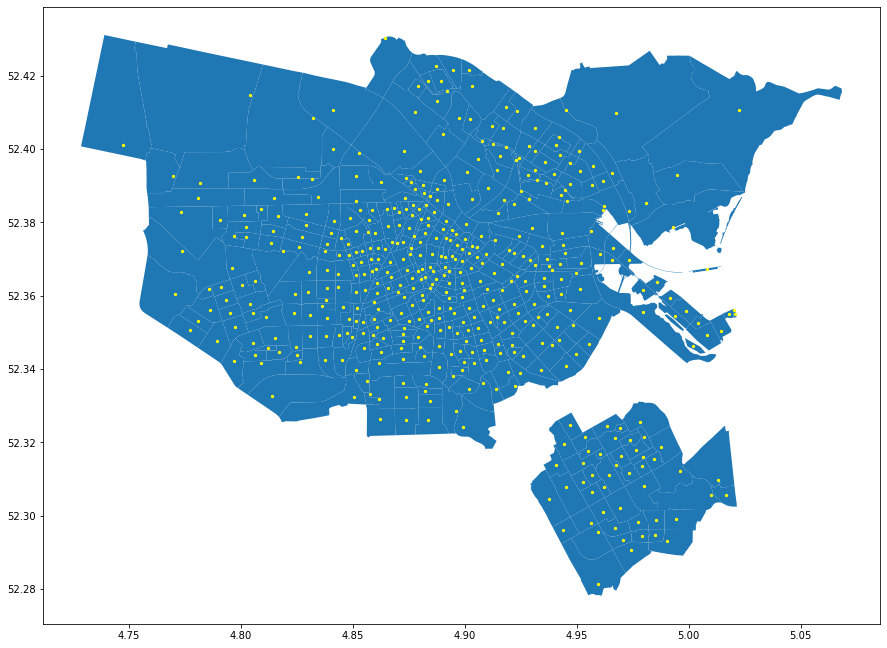

In [7]:
base = kwb_19_ams_neighborhoods.plot(figsize=(15,15))
kwb_19_ams_neighborhoods.res_centroid.plot(ax=base, color='yellow', markersize = 5, figsize=(15,15))

In [ ]:
kwb_ams_nhs = kwb_19_ams_neighborhoods
col = 'p_hh_li'
point = kwb_ams_nhs.res_centroid[kwb_19_ams_neighborhoods[col].isna()].to_crs('epsg:32631').iloc[0]
non_nan_areas = kwb_ams_nhs[~kwb_ams_nhs[col].isna()]
distances = non_nan_areas.res_centroid.to_crs('epsg:32631').distance(point).sort_values()
closest_distances_idxs = distances.index[:3]
closest_distances = distances.loc[closest_distances_idxs]
closest_entries = non_nan_areas.loc[closest_distances_idxs]

In [ ]:
closest_entries[col]*(1/closest_distances)/(1/closest_distances.sum())

In [ ]:
def inverse_dist_weighted_average(weights, values):
    return sum([(1/weight) * value / sum(1/weights) for weight, value in zip(weights, values)])

inverse_dist_weighted_average(np.array([1,2,3]),np.array([10,20,30]))

In [ ]:
for col in kwb_ams_nhs.columns:
    if kwb_ams_nhs[col].hasnans():
        nan_entries = kwb_ams_nhs[kwb_ams_nhs[col].isna()]
        for nan_entry in nan_entries:
            neighbour_nhs = kwb_ams_nhs[kwb_ams_nhs.geometry.touches(nan_entry.geometry)]
            distances = non_nan_areas.res_centroid.to_crs('epsg:32631').distance(point).sort_values()

<AxesSubplot:>

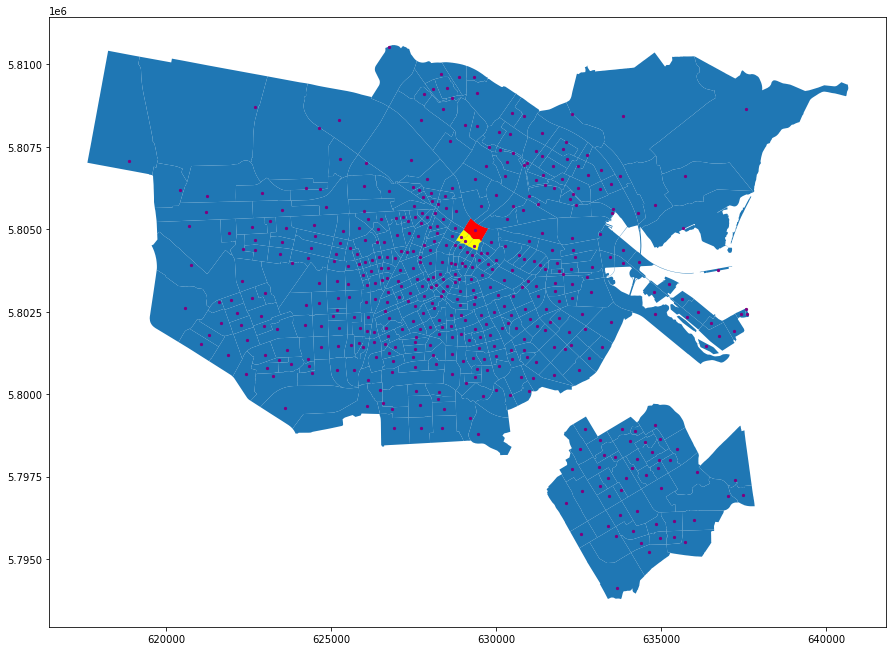

In [16]:
base = kwb_19_ams_neighborhoods.to_crs('epsg:32631').plot(figsize=(15,15))
base = kwb_ams_nhs.iloc[[5]].to_crs('epsg:32631').plot(ax=base, color='red', figsize=(15,15))
base = kwb_ams_nhs.iloc[closest_distances_idxs].to_crs('epsg:32631').plot(ax=base, color='yellow', figsize=(15,15))
kwb_19_ams_neighborhoods.res_centroid.to_crs('epsg:32631').plot(ax=base, color='purple', markersize = 5, figsize=(15,15))

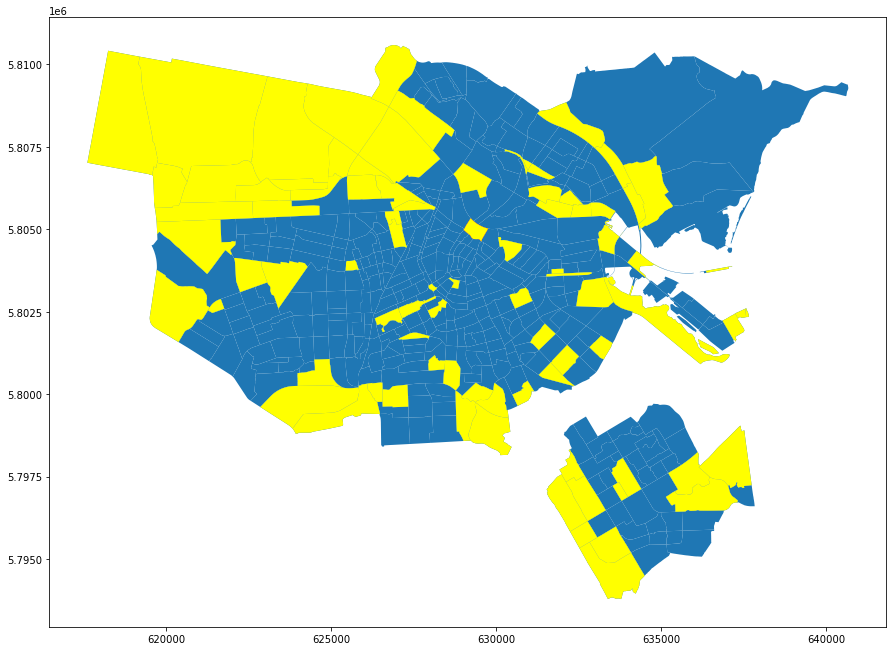

In [20]:
base = kwb_19_ams_neighborhoods.to_crs('epsg:32631').plot(figsize=(15,15))
base = kwb_ams_nhs.iloc[[5]].to_crs('epsg:32631').plot(ax=base, color='red', figsize=(15,15))
base = kwb_19_ams_neighborhoods[kwb_19_ams_neighborhoods[col].isna()].to_crs('epsg:32631').plot(ax=base, color='yellow', figsize=(15,15))

In [ ]:
closest_entries

In [ ]:
closest_entries

# Equity Computation

In [ ]:
kwb_ams_nhs[kwb_19_ams_neighborhoods[col].isna()].to_crs('epsg:32631').iloc[0]

In [ ]:
months = {i: {} for i in range(1,13)}
loaded_od_mats = {2019: months, 2020: months, 2021: months}
for od_mat in od_mats:
    with open(od_mat, 'rb') as fp:
        # tt_mx, td_mx, modes_mx, lines_mx, hops_mx, failed
        tt_mx, td_mx, modes_mx, lines_mx, hops_mx, _ = pickle.load(fp)
    od_mat_date = re.findall('\d+',od_mat.name)[0]
    year = int(od_mat_date[:4])
    month = int(od_mat_date[4:6])
    day = int(od_mat_date[6:])
